<div>
<img src="QDC_Notebook_Header_Day-02.png"/>
</div>


# QDC Day 2 - Challenge Track B: Transpilation

**Welcome to Day 2 Track B of the Quantum Developer Challenge**, where we’ll focus on optimizing transpilation for the Quantum Approximate Optimization Algorithm (QAOA)! In this 2-hour challenge, you’ll dive into optimizing quantum circuits with Qiskit’s transpiler and the Qiskit Transpiler Service, using a QAOA cost function as the target workload.

Your goal today is to create a custom transpiler workflow that efficiently maps QAOA circuits onto a specified quantum architecture, reducing circuit depth and gate count while preserving fidelity.


Let’s jump in and get started with QDC Day 2!


# Table of Contents

**Track B: Experiment with custom pass managers**
* [**Track B: Deep Dive into Custom Transpilation Strategies**](#Track-B:-Experiment-with-custom-pass-managers---Deep-Dive-into-Custom-Transpilation-Strategies)
* [**Example: Custom optimal pass for QAOA**](#6.-Example:-Custom-optimal-pass-for-QAOA)
    * [*Exercise 1: Grand Finale*](#Exercise-1:-Grand-Finale)
 
**For access to the Track A notebook, please click [here](link).**

In [7]:
# Required packages
# %pip install qiskit
# %pip install qiskit-ibm-runtime
# %pip install qiskit-ibm-transpiler
# %pip install qiskit-aer
# %pip install colorama
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

In [8]:
# Imports
from colorama import Fore, Style
from qc_grader.challenges.qdc_2024_2 import grade_day2b_ex1, submit_name, submit_feedback_2b_1
from utils import score_func

## Track B: Experiment with custom pass managers - Deep Dive into Custom Transpilation Strategies

### Ready for the Next Challenge? </b> 

In Track B, you'll take your skills to the next level by diving deep into custom transpilation strategies. Here, you'll have the opportunity to write your own transpiler passes, experiment with advanced pass managers, and fine-tune your circuits like never before.

This next stage is all about pushing boundaries and seeing how far you can optimize your quantum circuits. It’s where the real challenge begins, and where you’ll truly master the art of quantum circuit optimization.

**Note: This section does not require you to do Track A - it and can be attempted standalone.**

Are you ready to take on the Track B Challenge? Let’s continue this journey and see how far you can go!




### Introduction

For those looking to push the limits of quantum circuit optimization, Track B offers a deeper exploration into custom transpilation strategies. This track is designed for participants who want to experiment with more sophisticated techniques, leveraging the full flexibility of Qiskit’s transpilation capabilities.

### Challenge Objectives

- **Optimize Beyond Defaults:** Move beyond preset configurations to develop and fine-tune custom pass managers that implement high-impact optimizations tailored to your circuit's unique requirements.
- **Explore Custom Transpiler Passes:** Attempt to create your own transpiler passes to address specific optimization challenges using your own approaches.
- **Experiment with Custom Staged Transpilation:** Utilize staged pass managers to structure the transpilation process into distinct phases and precisly control each stage of circuit transformation.

Benchmark your optimizations and test and iterate on your custom strategies, comparing them against standard presets to demonstrate your work's effectiveness against the grader.


For inspiration, here is an example of a custom transpilation pass strategy implemented by our IBM researchers.

## Example: Custom optimal pass for QAOA
This section shows how applying domain-specific transpilation strategies allows to reduce circuit depth and two-qubit gate count on QAOA circuits. 

*This section is from a notebook authored by Elena Peña Tapia, IBM Quantum. You can find the notebook here: [https://github.com/qiskit-community/qopt-best-practices/blob/main/how_tos/how_to_apply_optimal_qaoa_transpilation.ipynb](https://github.com/qiskit-community/qopt-best-practices/blob/main/how_tos/how_to_apply_optimal_qaoa_transpilation.ipynb)*

References:

[1] Sack, S. H., & Egger, D. J. (2023). Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation. arXiv preprint arXiv:2307.14427.

[2] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870. 

<div class="alert alert-block alert-warning">

<b> **Note:** </b> The problem setting in the example below is for $n=10$ and $m=7$.

</div>

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IZIIIIIIZI', 'IZIIIIIZII', 'ZIIIIIIZII', 'IZIIIIZIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


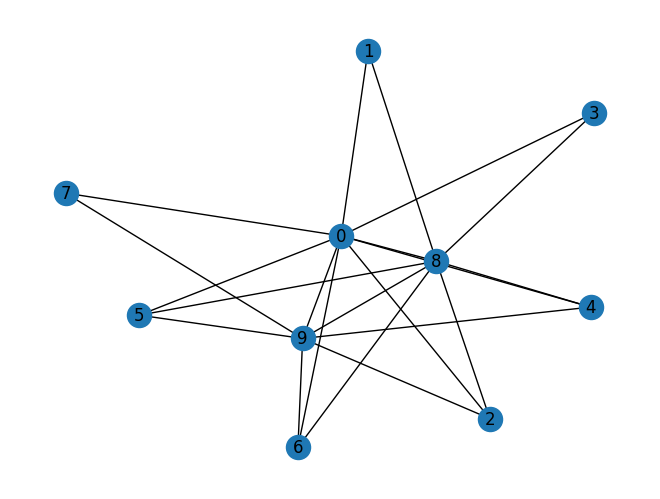

In [9]:
# Setup problem
from qiskit import QuantumCircuit
from networkx import barabasi_albert_graph, draw

graph = barabasi_albert_graph(n=10, m=7, seed=42)
draw(graph, with_labels=True)

# Build operators
from utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)
num_qubits = cost_operator.num_qubits

# Build cost_layer
# We are taking advantage of the QAOAAnsatz class to build the cost layer,
# note that we are giving it dummy initial state and mixer circuits.
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector

dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

# Define layers
num_qubits = cost_operator.num_qubits
qaoa_layers = 3

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="",
#     set_as_default=True,
#     # Use `overwrite=True` if you're updating your token.
#     overwrite=True,
# )

# Load saved credentials
service = QiskitRuntimeService(channel="ibm_quantum")

# Select backend
backend = service.backend("ibm_torino")

### Design a pass manager for cost layer transpilation

The cost layer transpilation stage will apply the swap strategies from [1,2] to optimally route the cost layer circuit into the connectivity of our backend. This collection of passes will insert swap gates to fit the circuit to the chip connectivity in a way that will allow to maximally cancel CNOT gates and reduce the total circuit depth.

Note that we are routing the circuit into a `line`, which proves to be optimal in most QAOA cases. To make sure that the line fits into our chip, we use the `BackendEvaluator` utility before committing to the swap strategy:

In [11]:
from utils import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
og_path_finder = BackendEvaluator(backend)
og_path, fidelity, num_subsets = og_path_finder.evaluate(num_qubits)
print(og_path, fidelity)

[46, 55, 65, 66, 67, 74, 86, 87, 88, 94] 0.9814794486748111


The collection of passes defined below will be embedded into the "pre_init" stage of our `StagedPassManager`.

In [12]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    CommutativeCancellation,
    Decompose,
    CXCancellation,
    HighLevelSynthesis,
    InverseCancellation,
    SabreSwap,
    SabreLayout,
    ApplyLayout,
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate

In [13]:
num_qubits = 10

# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        HighLevelSynthesis(basis_gates=["PauliEvolution"]),
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        ),
        HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

We can run this pass manager independently to confirm that it performs the desired transformations:

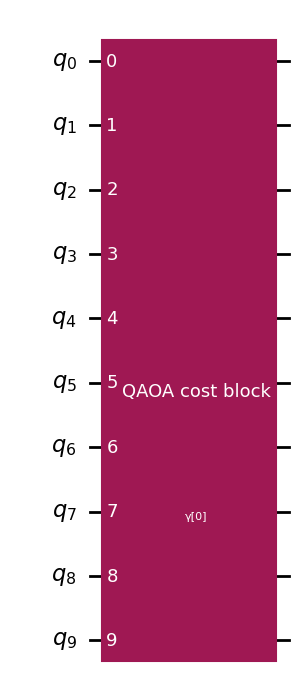

In [14]:
cost_layer.draw(output="mpl", fold=-1)

OrderedDict({'cx': 42, 'u1': 21})


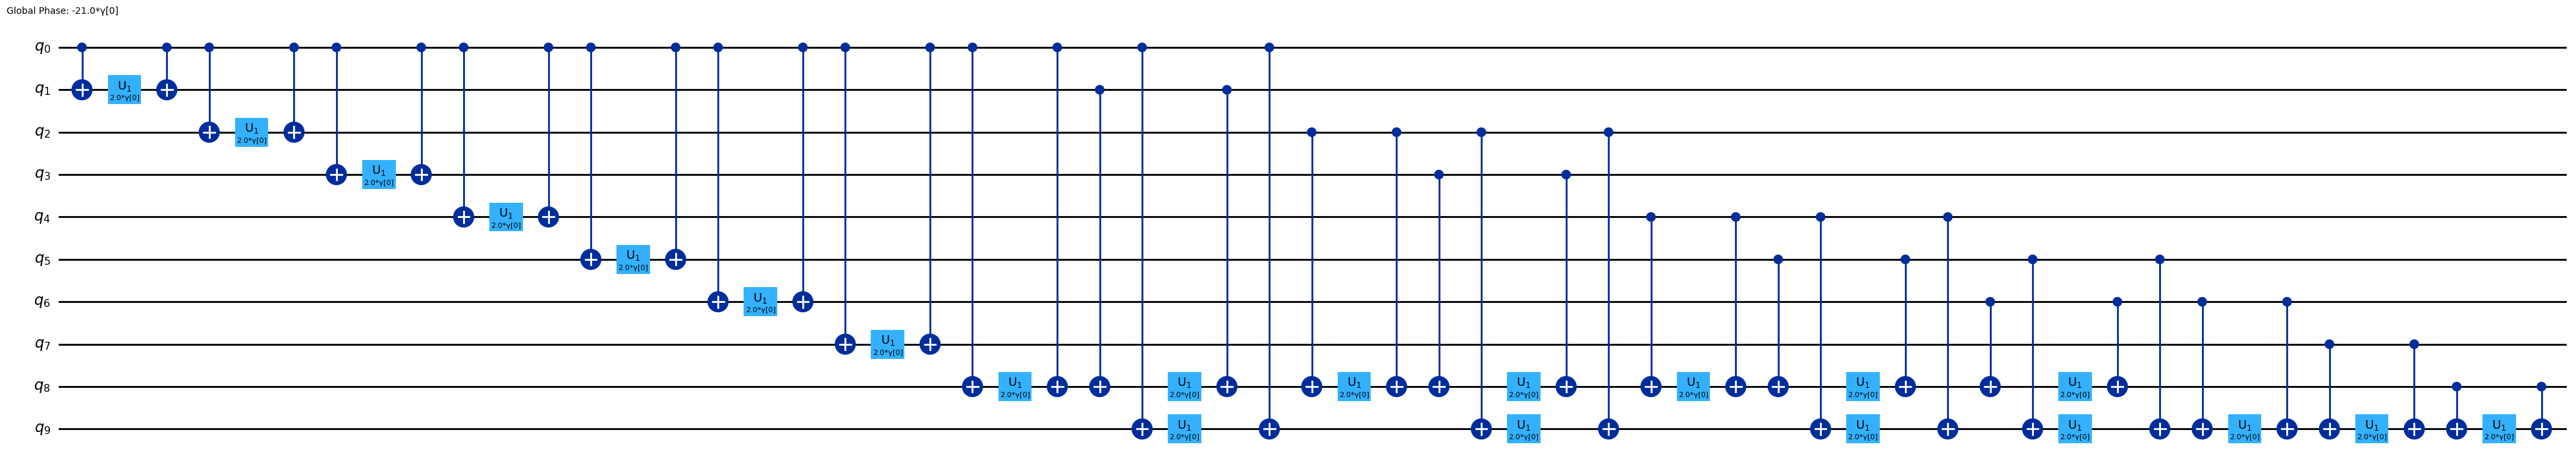

In [15]:
# Before:
print(cost_layer.decompose(reps=4).count_ops())
cost_layer.decompose(reps=4).draw("mpl", fold=-1)

In [16]:
tmp = pre_init.run(cost_layer)

OrderedDict({'cx': 114, 'rz': 21})


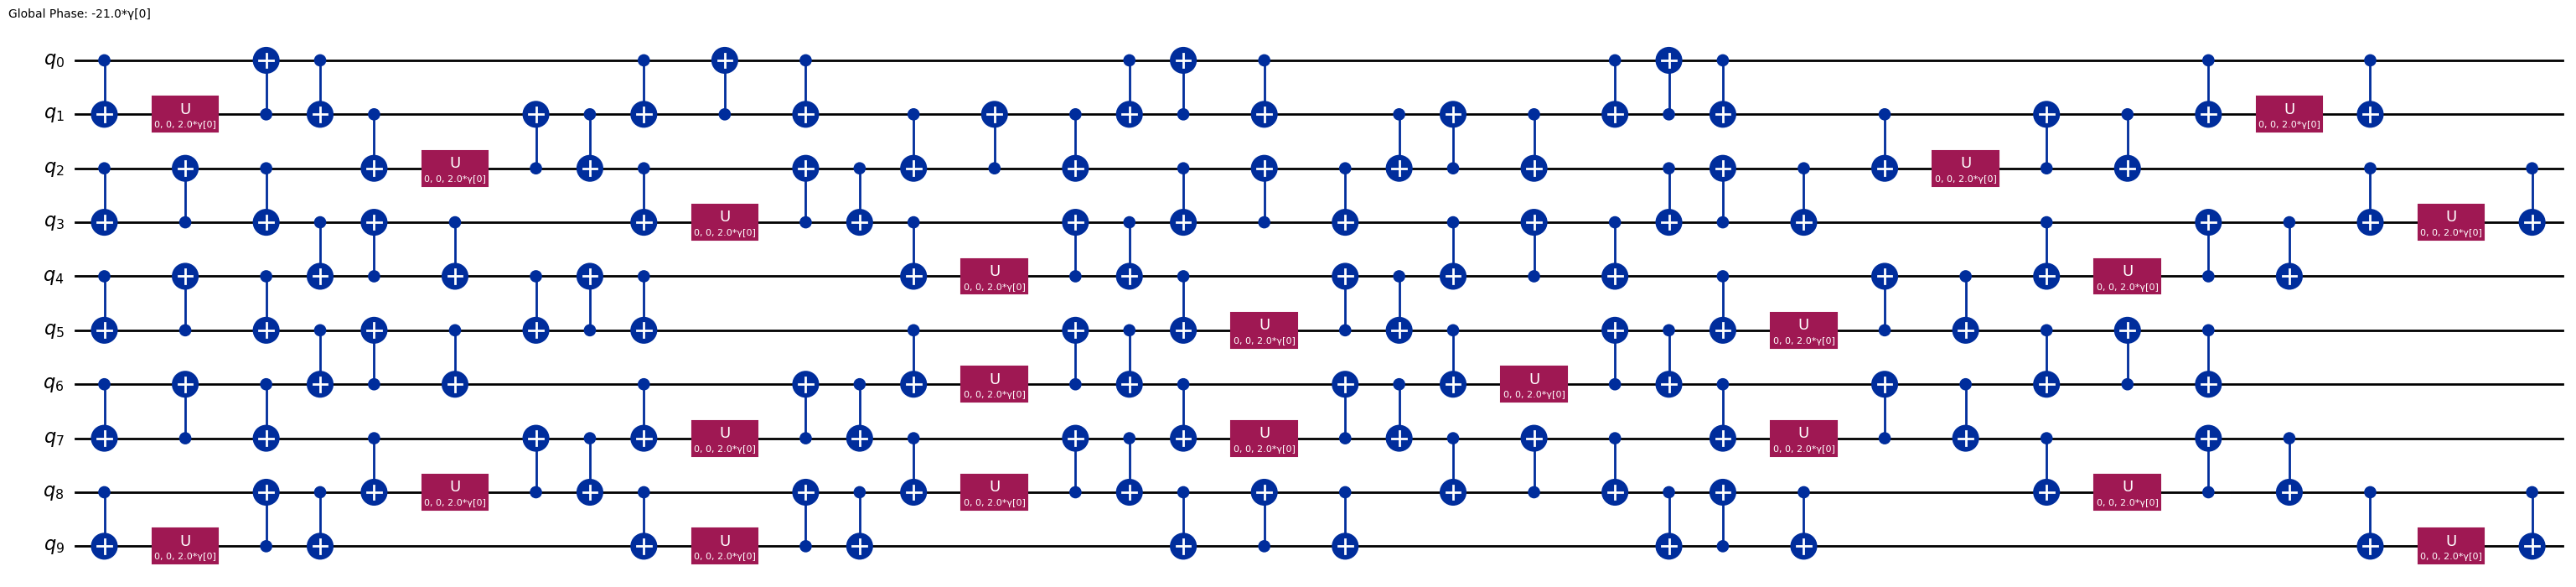

In [17]:
# After:
print(tmp.count_ops())
tmp.decompose().decompose().decompose().draw("mpl", fold=-1)

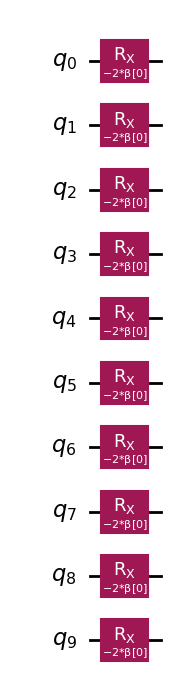

In [18]:
# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2 * betas[0], range(num_qubits))
mixer_operator.draw(output="mpl", fold=-1)

In [19]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import circuit_to_dag, dag_to_circuit


class QAOAPass(TransformationPass):
    def __init__(self, num_layers, num_qubits, init_state=None, mixer_layer=None):
        super().__init__()
        self.num_layers = num_layers
        self.num_qubits = num_qubits

        if init_state is None:
            # Add default initial state -> equal superposition
            self.init_state = QuantumCircuit(num_qubits)
            self.init_state.h(range(num_qubits))
        else:
            self.init_state = init_state

        if mixer_layer is None:
            # Define default mixer layer
            self.mixer_layer = QuantumCircuit(num_qubits)
            self.mixer_layer.rx(-2 * betas[0], range(num_qubits))
        else:
            self.mixer_layer = mixer_layer

    def run(self, cost_layer_dag):
        cost_layer = dag_to_circuit(cost_layer_dag)
        qaoa_circuit = QuantumCircuit(self.num_qubits, self.num_qubits)
        # Re-parametrize the circuit
        gammas = ParameterVector("γ", self.num_layers)
        betas = ParameterVector("β", self.num_layers)

        # Add initial state
        qaoa_circuit.compose(self.init_state, inplace=True)

        # iterate over number of qama layers
        # and alternate cost/reversed cost and mixer
        for layer in range(self.num_layers):
            bind_dict = {cost_layer.parameters[0]: gammas[layer]}
            bound_cost_layer = cost_layer.assign_parameters(bind_dict)

            bind_dict = {self.mixer_layer.parameters[0]: betas[layer]}
            bound_mixer_layer = self.mixer_layer.assign_parameters(bind_dict)

            if layer % 2 == 0:
                # even layer -> append cost
                qaoa_circuit.compose(bound_cost_layer, range(self.num_qubits), inplace=True)
            else:
                # odd layer -> append reversed cost
                qaoa_circuit.compose(bound_cost_layer.reverse_ops(), range(self.num_qubits), inplace=True)

            # the mixer layer is not reversed
            qaoa_circuit.compose(bound_mixer_layer, range(self.num_qubits), inplace=True)

        if self.num_layers % 2 == 1:
            # iterate over layout permutations to recover measurements
            if self.property_set["virtual_permutation_layout"]:
                for cidx, qidx in self.property_set["virtual_permutation_layout"].get_physical_bits().items():
                    qaoa_circuit.measure(qidx, cidx)
            else:
                print("layout not found, assigining trivial layout")
                for idx in range(self.num_qubits):
                    qaoa_circuit.measure(idx, idx)
        else:
            for idx in range(self.num_qubits):
                qaoa_circuit.measure(idx, idx)

        return circuit_to_dag(qaoa_circuit)

Once again, let's check that this custom pass runs and builds a QAOA circuit with three layers:

In [20]:
init = PassManager([QAOAPass(num_layers=3, num_qubits=10)])

layout not found, assigining trivial layout
OrderedDict({'cx': 342, 'rz': 63, 'rx': 30, 'h': 10, 'measure': 10})


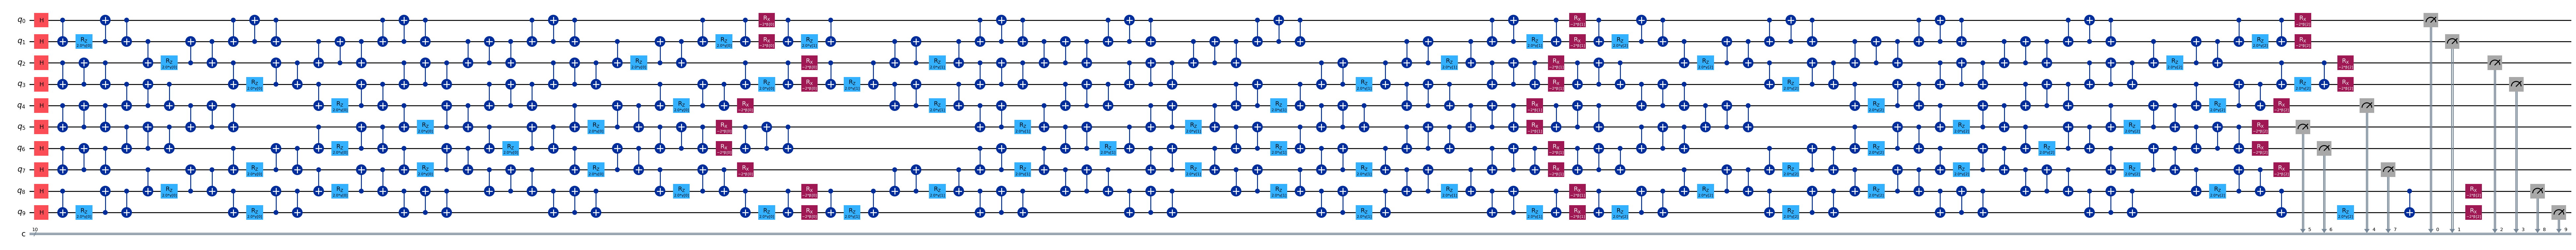

In [21]:
tmp_out = init.run(tmp)
print(tmp_out.count_ops())
tmp_out.draw("mpl", fold=-1)

### Complete the pipeline

Now that we can build our optimized QAOA ansatz, we need to fill out the remaining stages of the pipeline. We can use as a reference the output of the preset pass manager and replace the init, pre-init, and post-init stages with our custom pass managers. We need to define a "post_init" step that takes care of the basis translation part to match the expected output in the default pipeline.

In [22]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(og_path, cost_layer.qregs[0])

In [23]:
# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names, min_qubits=3),
        BasisTranslator(_sel, target_basis=backend.operation_names, min_qubits=3),
    ]
)

In [24]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.init = init
staged_pm.post_init = post_init
# staged_pm.routing = None

### Run the StagedPassManager

In [25]:
import time

t0_opt = time.time()
optimally_transpiled_qaoa = staged_pm.run(cost_layer)
t1_opt = time.time()

In [26]:
# Print transpilation time
print(f"Transpilation time: {t1_opt - t0_opt:.2f} seconds")

circuit = optimally_transpiled_qaoa
# Output various metrics about the transpiled circuit
print(f"Count Ops: {circuit.count_ops()}")
print(f"Total circuit depth: {circuit.depth()}")
print(f"Number of 2-qubit gates: {circuit.size(lambda x: x.operation.num_qubits == 2)}")

# Output the score and depth specifically for 2-qubit gates, in color
print(Fore.MAGENTA + Style.BRIGHT + f"2-qubit gate depth: {circuit.depth(lambda x: x.operation.num_qubits == 2)}")
print(Fore.GREEN + f"Score: {score_func(circuit)}")

Transpilation time: 0.19 seconds
Count Ops: OrderedDict({'rz': 690, 'sx': 656, 'cz': 342, 'measure': 10, 'x': 2})
Total circuit depth: 301
Number of 2-qubit gates: 342
2-qubit gate depth: 78
Score: 100


## Exercise 1: Grand Finale
<a id="exercise1"></a>
<div class="alert alert-block alert-success">
<b>Exercise 1: Advanced Circuit Optimization</b>

Let's use all the capabilities of the Qiskit SDK's transpiler and Transpiler Service to achieve the best results. You are free to use any approach you wish as long as you **build a Custom Pass Manager or leverage a Staged Pass Manager**


**Goal:** Obtain a quantum circuit with the best possible metrics through advanced transpilation techniques. Focus on optimizing metrics such as CNOT count, SWAP count, and total circuit depth. Demonstrate the scalability of your methods to larger circuits. Aim for at least a 5-10% reduction in both two-qubit gate count and circuit depth compared to the AI transpiler service or an optimal solution, while maintaining or improving transpilation time complexity.

**Some helpful documentation links for this exercise:**
- [Create a custom PassManager](https://docs.quantum.ibm.com/guides/dynamical-decoupling-pass-manager)
- [Write your own custom transpiler pass](https://docs.quantum.ibm.com/guides/custom-transpiler-pass)
- [Installing and using transpiler plugins](https://docs.quantum.ibm.com/guides/transpiler-plugins)
- [Create a transpiler plugin](https://docs.quantum.ibm.com/guides/create-transpiler-plugin)

</div> 


In [27]:
# Setup problem
from qiskit import QuantumCircuit
from networkx import barabasi_albert_graph, draw

graph = barabasi_albert_graph(n=50, m=7, seed=42)

# Build operators
from utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
num_qubits = cost_operator.num_qubits
qaoa_layers = 3

# Build cost_layer
# We are taking advantage of the QAOAAnsatz class to build the cost layer,
# note that we are giving it dummy initial state and mixer circuits.
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector

# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2 * betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state=initial_state,
    mixer_operator=mixer_operator,
    reps=qaoa_layers,
)
# Bug, needs to be commented
# qaoa_ansatz.measure_all()

In [28]:
qaoa_ansatz.decompose().decompose().decompose().draw(fold=-1)

┌─────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [29]:
from qiskit.transpiler import Layout

# New path
qlists = backend.properties().general_qlists
path = next(qlist["qubits"] for qlist in qlists if qlist["name"] == f"lf_{num_qubits:d}")

# Original Path
# path_finder = BackendEvaluator(backend)
# path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

# Compute initial_layout
initial_layout = Layout.from_intlist(path, qaoa_ansatz.qregs[0])

In [32]:
# New path
qlists = backend.properties().general_qlists
path = next(qlist["qubits"] for qlist in qlists if qlist["name"] == f"lf_{num_qubits:d}")

# Compute initial_layout
initial_layout = Layout.from_intlist(path, qaoa_ansatz.qregs[0])

new_pre_init = PassManager(
    [
        HighLevelSynthesis(),
        InverseCancellation(gates_to_cancel=[CXGate()]),
        HighLevelSynthesis(),
    ]
)

pm_ex1 = generate_preset_pass_manager(
    3,
    backend,
    routing_method="stochastic",
    layout_method="sabre",
    initial_layout=initial_layout,
)
pm_ex1.pre_init = new_pre_init

In [33]:
### Write your code below here ###

from qiskit.transpiler import PassManager, TransformationPass, generate_preset_pass_manager
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler.passes import EnlargeWithAncilla
from qiskit.transpiler.passes import ApplyLayout
from qiskit.transpiler.passes import SetLayout, FullAncillaAllocation

# swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
# edge_coloring = {(edges[0], edges[1]): (edges[1]) % 2 for edges in backend.coupling_map}

# # new_pre_init = PassManager(
# #     [
# #         HighLevelSynthesis(),
# #         # FindCommutingPauliEvolutions(),
# #         # Commuting2qGateRouter(swap_strategy),
# #         # SetLayout(initial_layout),
# #         InverseCancellation(gates_to_cancel=[CXGate()]),
# #         HighLevelSynthesis(),
# #         InverseCancellation(gates_to_cancel=[CXGate()]),
# #         HighLevelSynthesis(),
# #         InverseCancellation(gates_to_cancel=[CXGate()]),
# #     ]
# # )

# new_pre_init = PassManager(
#     [
#         HighLevelSynthesis(basis_gates=["PauliEvolution"]),
#         FindCommutingPauliEvolutions(),
#         Commuting2qGateRouter(
#             swap_strategy,
#             edge_coloring,
#         ),
#         HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
#         InverseCancellation(gates_to_cancel=[CXGate()]),
#     ]
# )


# class FullQAOAPass(TransformationPass):
#     def run(self, full_circuit):
#         full_circuit = dag_to_circuit(full_circuit).decompose().decompose()
#         new_circuit = QuantumCircuit(full_circuit.num_qubits, full_circuit.num_qubits)
#         for block in full_circuit:
#             if block.name in ["h", "rx"]:
#                 new_circuit.compose(block, range(full_circuit.num_qubits), range(full_circuit.num_qubits), inplace=True)
#             elif block.name == "PauliEvolution":
#                 new_circuit.compose(
#                     new_pre_init.run(block),
#                     range(full_circuit.num_qubits),
#                     range(full_circuit.num_qubits),
#                     inplace=True,
#                 )
#             else:
#                 new_circuit.compose(block, range(full_circuit.num_qubits), range(full_circuit.num_qubits), inplace=True)
#         return circuit_to_dag(new_circuit)


# from qiskit.transpiler.basepasses import TransformationPass
# from qiskit.converters import circuit_to_dag, dag_to_circuit

# pm_ex1 = generate_preset_pass_manager(
#     3,
#     backend,
#     # routing_method="stochastic",
#     # layout_method="sabre",
#     # initial_layout=initial_layout,
# )
# pm_ex1.pre_init = PassManager([FullQAOAPass()])
# # pm_ex1.routing = PassManager([Commuting2qGateRouter(swap_strategy, edge_coloring)])

### Don't change any code past this line ###

circuit = pm_ex1.run(qaoa_ansatz)

# Output various metrics about the transpiled circuit
print(f"Count Ops: {circuit.count_ops()}")
print(f"Total circuit depth: {circuit.depth()}")
print(f"Number of 2-qubit gates: {circuit.size(lambda x: x.operation.num_qubits == 2)}")

# Output the score and depth specifically for 2-qubit gates, in color
print(Fore.MAGENTA + Style.BRIGHT + f"2-qubit gate depth: {circuit.depth(lambda x: x.operation.num_qubits == 2)}")
print(Fore.GREEN + f"Score: {score_func(circuit)}")

Count Ops: OrderedDict({'sx': 25073, 'cz': 12745, 'rz': 7588, 'x': 25})
Total circuit depth: 4436
Number of 2-qubit gates: 12745
2-qubit gate depth: 1788
Score: 2056


In [ ]:
# Please choose your username for the leaderboard

username = "GuillermoAbadLopez"
submit_name(username)

In [255]:
# Run this cell to grade your answer
for _ in range(10):
    grade_day2b_ex1(pm_ex1, backend)

Grading complete! Running iteration 5: [████████████████████████████████████████] 100.00% (5/5)
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 2143.
Grading complete! Running iteration 5: [████████████████████████████████████████] 100.00% (5/5)
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 2029.
Grading complete! Running iteration 5: [████████████████████████████████████████] 100.00% (5/5)
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 2135.
Grading complete! Running iteration 5: [████████████████████████████████████████] 100.00% (5/5)
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 2047.
Grading complete! Running iteration 5: [████████████████████████████████████████] 100.00% (5/5)
Submitting your answ

In [ ]:
from qiskit_algorithms import QAOA

<div class="alert alert-block alert-success">
<b>Make the most of the in-person QDC experience</b>
    
Feel free to experiment with the different transpiler passes and strategies to discover the different ways they can add value to your quantum projects. Please do not hesitate to reach out to the mentors and IBMers in the room to ask questions and learn how to unlock even more potential from each of these capablities!

</div>

<div class="alert alert-block alert-info">

💬 **Feedback:**  How valuable do you find the option to customize your transpiler pass beyond the default options? Why?
</div>

In [65]:
# Submit your feedback here

feedback = "This challenge was much better than yesterday's! I really enjoyed it. (Yesterday one, would be better if didn't just play with 2 integers)."
submit_feedback_2b_1(feedback)
# Expected result type: String

Submitting your answer. Please wait...
Thanks for your feedback!




## Congratulations on Completing Day 2! </b>

You've successfully completed this challenge, where you've gained a solid understanding of Qiskit’s transpilation process and learned how to optimize quantum circuits using preset pass managers. Your ability to navigate through the basics and apply these optimizations is a significant achievement. 

Feel free to refer back to this notebook, check out the other [track](), revisit exercises, or try some of the optional sections to refine your skills. We hope this journey has inspired you to push the boundaries of quantum computing!

Thank you for taking part in the Day 2 of the challenge! We look forward to seeing you continue your quantum journey. 

**Happy Coding and Quantum Computing – see you tomorrow!**

# Additional information

**Created by:** Elena Peña Tapia, Junye Huang, Vishal Sharathchandra Bajpe

**Advised by:** Abby Mitchell, Ali Javadi, Alexander Ivrii, Bryce Fuller, Henry Zou, John Lapeyre, Matthew Trenish,  Shelly Garion

**Version:** 1.2.0